In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math

In [3]:
# Define the model equations
def microbial_model(y, t, g, l, c, e, m, kappa, omega, D):
    N = y[:2]
    R = y[2:]
    
    # Species growth term
    growth_term = (c @ R) * (1 - l) - m
    
    # Resource consumption and production term
    consumption_term = N @ (e * R)
    production_term = np.sum([l * np.dot(D, (c[i, :] * R)) * N[i] for i in range(len(N))], axis=0)

    # Differential equations
    dN = N * g * (growth_term)
    dR = kappa - omega * R - consumption_term + production_term

    return np.concatenate([dN, dR])


In [4]:
denit_D = np.array([[0.0, 0.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.0]]
                  )
pH_neutral = 7.0
pH_min = 1.0

                  
def sampleE(k=2.0):
    '''
    Samples a new denitrification impact matrix as per 
    tradeoff in Kyle's paper.
    
    The k parameter controls the curvature.
    '''
    d = 1.0
    a = 1.0

    ne = []
    for _ in range(S):
        rA = np.random.uniform()
        rI = a * ((d - (rA/a)**k)**(1/k))

        ne.append([rA, rI, 0.0])
    
    return np.array(ne)

def sampleC(E, pH=7.0):
    nc = E.copy()
    for sp in range(E.shape[0]):
        if pH > pH_min:
            nc[sp] *= ((pH - pH_min) / (pH_neutral - pH_min))
    
    return np.array(nc)

In [5]:
S = 2   # Number of species
M = 3   # Number of resources

# General systematic case

In [27]:
delNs = {}
NUM_SAMPLES = 50

for deg_generalism in [0.6, .0]:
    this_delNs = []
    for _ in range(NUM_SAMPLES):
        N1 = [0.0]
        N2 = [0.0]
        
        while (np.isclose(N1[-1],0.0) and np.isclose(N2[-1], 0.0)):
            e = sampleE(k=2.0)                          # Impact matrix
            D = denit_D   
            k = np.random.normal(0.6, 0.1, S)          # Growth rate
            # if deg_generalism != 0.0:
            off_diags = np.random.normal(deg_generalism, 0.05, S)  # Off-diagonal terms
            # else:
                # off_diags = np.random.normal(deg_generalism, 0.00, S)  # Off-diagonal terms
            e = np.array([[k[0], off_diags[0], 0.0],
                         [off_diags[1], k[1], 0.0]])

            old_pH = 7.0
            c = sampleC(e, pH=old_pH)   # Consumption matrix at neutral pH

            # Parameters
            g = np.array([1.0, 1.0])  # Growth rates for species 1 and 2
            l = 0.7  # Leakage fraction
            omega = np.array([1.0, 1.0, 3.0])  # Decay rate of resources; waste decays faster

            # Initial conditions
            initial_N = np.array([1.5, 1.5])  # Initial population sizes for species 1 and 2
            initial_R = np.array([1.0, 1.0, 0.0])  # Initial resource levels for resources 1, 2, and 3
            initial_conditions = np.concatenate([initial_N, initial_R])

            # Key control parameters.
            kappa = np.array([20.0, 0.0, 0.0])  # Supply rates for resources 1, 2, and 3
            m = np.array([1.0, 1.0])  # Maintenance energies for species 1 and 2

            m_old = m.copy()
            kappa_old = kappa.copy()
            c_old = c.copy()

            # Time grid for integration
            t = np.linspace(0, 300, 500)

            # Solve the differential equations
            solution = odeint(microbial_model, initial_conditions, t, args=(g, l, c, e, m, kappa, omega, D))

            # Extract the results
            N1, N2 = solution[:, 0], solution[:, 1]
            R1, R2, R3 = solution[:, 2], solution[:, 3], solution[:, 4]

        # If succeeds
        m_new = m.copy()
        kappa_new = kappa.copy()

        dpH = 0.05
        new_pH = old_pH - dpH
        c = sampleC(e, pH=new_pH)   # Consumption matrix at new pH

        # Solve the differential equations
        solution = odeint(microbial_model, initial_conditions, t, args=(g, l, c, e, m, kappa, omega, D))

        # Extract the results
        N1f, N2f = solution[:, 0], solution[:, 1]
        R1f, R2f, R3f = solution[:, 2], solution[:, 3], solution[:, 4]

        delN = np.array([N1f[-1] - N1[-1], N2f[-1] - N2[-1]])
        delR  = np.array([R1f[-1] - R1[-1], R2f[-1] - R2[-1]])
        this_delNs.append(delN)

    delNs[deg_generalism] = this_delNs.copy()

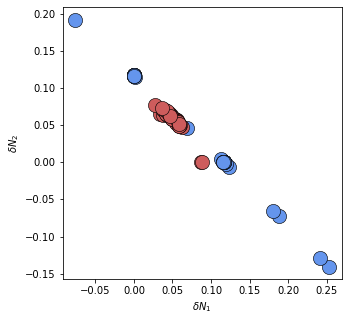

In [32]:
# Create a scatter plot
plt.figure(figsize=(5, 5))

# Define colors for each key
colors = ['cornflowerblue', 'indianred']

# Plot each key with a different color
for i, (key, points) in enumerate(delNs.items()):
    for point in points:
        plt.scatter(-point[0], -point[1], color=colors[i], s=200, lw=0.6, 
                    edgecolors='black', label=f'key={key}')
# plt.xlim(-0.20, 0.20)
# plt.ylim(-0.20, 0.20)
# Add labels and legend
plt.xlabel(r'$\delta N_1$')
plt.ylabel(r'$\delta N_2$')

plt.savefig('comp_coop_figs/gen_spec_statistics_broad.svg')

# Show plot
plt.show()